In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

import theano_shim as shim
import sinn
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz

import main
import fsgif_model as fsgif

import copy

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
[monochrome_palette]: value was greater than 1 and was clipped.


# Data generation

Generate spike trains. If the specified filename already exists, the precomputed data is used instead.

*Note*: Spike trains use relatively fine time bins (0.2&nbsp;ms). This is because spike times must be precise relative to the timescale of the PSP kernel (i.e. $τ_m$).

In [2]:
datalen = 4  # Use 4 seconds of data

spikemodel = main.generate_spikes(datalen,
                                  filename='fsgif_{}s_sin-input_hi-res.dat'.format(datalen))

2017-06-20 13:11:37,769 - root - INFO - Checking for precomputed data...
2017-06-20 13:12:22,432 - root - INFO - Precomputed data found. Skipping data generation


In [3]:
shist = spikemodel.s
spikeIhist = spikemodel.I_ext
true_params = copy.deepcopy(spikemodel.params)
model_params = copy.deepcopy(true_params)

Compute the activity trace by summing over spikes. We subsample the result because the activity trace uses a coarser time bin of 1&nbsp;ms.

*Note*: When subsampling, we average over $n$ bins and combine into one, so we aren't just throwing away 80% of our data.

In [4]:
spikeAhist = Series(shist, name='A', shape=(len(shist.pop_slices),))
summedspikes = np.concatenate(
    [ shist._data.tocsr()[shist.t0idx: shist.t0idx + len(shist), pop_slice].sum(axis=1).A
      for pop_slice in shist.pop_slices ],
    axis=1)
spikeAhist.set(summedspikes / (model_params.N * shist.dt))
spikeAhist.lock()

# Subsample the activity and input
Ahist = anlz.subsample(spikeAhist, np.rint(main.mf_dt / main.spike_dt).astype('int'))
Ahist.lock()
Ihist = anlz.subsample(spikeIhist, np.rint(main.mf_dt / main.spike_dt).astype('int'))
Ihist.lock()

# Remove dependencies of the subsampled data on the original
# (this is to workaround some of sinn's intricacies)
sinn.inputs[Ahist].clear()
sinn.inputs[Ihist].clear()

Plot the generated data.

In [5]:
data = spikemodel.s._data
lineheight = 1
markersize = 1
maxN = None
burnin = 0.0
datalen = 4

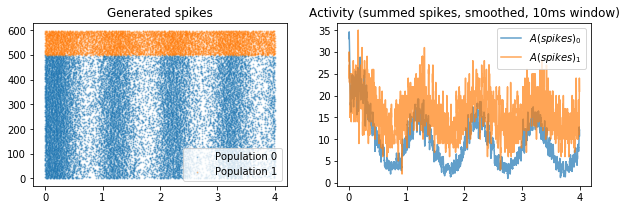

In [6]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title("Generated spikes")
for i, popslice in enumerate(spikemodel.s.pop_slices):
    tarr = spikemodel.s._tarr[data.row]
    tidcs = np.where(np.logical_and(burnin < tarr, tarr < burnin+datalen))[0]
    popidcs = np.where(np.logical_and(popslice.start <= data.col, data.col < popslice.stop))[0]
    idcs = np.intersect1d(tidcs, popidcs)
    plt.scatter(spikemodel.s._tarr[data.row[idcs]], data.col[idcs]*lineheight, 
                s=markersize, linestyle='None', label="Population {}".format(i),
                alpha=0.3)
plt.legend()

plt.subplot(1,2,2)
plt.title("Activity (summed spikes, smoothed, 10ms window)")
anlz.plot(anlz.smooth(Ahist, 10), label='A (spikes)', alpha=0.7)
plt.legend()

Create the activity model we will fit, with activity trace and input constrained by the spike data.

In [7]:
main.load_theano()

In [8]:
def convert_to_theano(obj):
    if isinstance(obj, sinn.common.HistoryBase):
        hist = obj
        for attrname in dir(hist):
            attr = getattr(hist, attrname)
            if isinstance(attr, shim.ShimmedShared):
                setattr(hist, attrname,
                        shim.shared(attr.get_value(), name=attr.name))
    else:
        # Assume obj is a Parameters instance
        # TODO: When Parameters are subclasses, test for the base class
        param_dict = obj._asdict()
        for key, val in param_dict.items():
            if isinstance(val, shim.ShimmedShared):
                param_dict[key] = shim.shared(val.get_value(), name=val.name)
        return param_dict
            

In [9]:
convert_to_theano(Ahist)

In [10]:
convert_to_theano(Ihist)

In [11]:
model_paramsT = fsgif.GIF_mean_field.Parameters(**convert_to_theano(model_params))

In [12]:
#spikemodel = fsgif.GIF_spiking(model_params, shist, Ihist, memory_time = memory_time)
mfmodel = main.init_mean_field_model(Ahist,
                                     Ihist,
                                     model_params=model_paramsT)

/home/rene/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-20 13:13:30,981 - theano_shim - INFO - Adding Theano update : n data -> IncSubtensor{Set;int64:int64:}.0
2017-06-20 13:13:30,982 - theano_shim - INFO - Adding Theano update : t idx (n) -> Elemwise{switch,no_inplace}.0


In [13]:
model_paramsT.Δ.eval()

array([[ 0.001,  0.001],
       [ 0.001,  0.001]])

# Visual validation

To check that the models are consistent, we instantiate a second mean-field model with the same input but let it compute the activity trace. We check that the trace it produces is consistent with the one we will fit to.

In [6]:
mfmodel_unconstrained = main.init_mean_field_model(activity_history = None,
                                                   input_history = Ihist,
                                                   model_params = mfmodel.params)

mfmodel_unconstrained.A.name = 'A (mf)'

In [7]:
mfmodel_unconstrained.A.set()  # Compute A

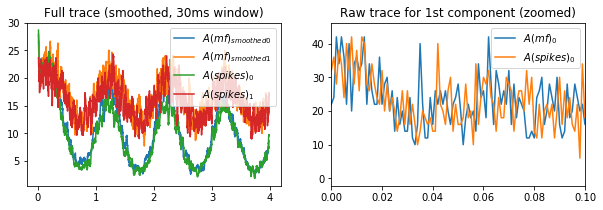

In [9]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title("Full trace (smoothed, 30ms window)")
anlz.plot(anlz.smooth(mfmodel_unconstrained.A, 30))
anlz.plot(anlz.smooth(Ahist, 30), label='A (spikes)')
plt.legend()

plt.subplot(1,2,2)
plt.title("Raw trace for 1st component (zoomed)")
anlz.plot(mfmodel_unconstrained.A, component=0)
anlz.plot(Ahist, label='A (spikes)', component=0)
plt.legend()
plt.xlim((0.0, 0.1))

None

# Likelihood sweep

In [13]:
# Probability is actually computed with number of spikes (n)
# rather than spikes / neuron / s (A).
mfmodel.n.set()
mfmodel.n.lock()

In [14]:
# Workaround for issue with `sinn`
spikemodel.λ.name = 'spikeλ'
spikemodel.u.name = 'spikeu'

histnames_to_delete = ['A_subsampled_by_5_smoothed']
dellist = []
for h in mfmodel.history_inputs:
    if h.name in histnames_to_delete:
        dellist.append(h)
for h in dellist:
    del mfmodel.history_inputs[h]
    
dellist = []
for h in sinn.inputs:
    if h.name in histnames_to_delete:
        dellist.append(h)
for h in dellist:
    del sinn.inputs[h]

In [15]:
shim.cf.theano_updates

OrderedDict([(n data, IncSubtensor{Set;int64:int64:}.0),
             (t idx (n), Elemwise{switch,no_inplace}.0)])

In [16]:
tidx = shim.getT().scalar('tidx', dtype='int32')
output_res_idx = mfmodel.nbar[tidx]

/home/rene/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-20 13:13:31,367 - theano_shim - INFO - Adding Theano update : A_Δ data -> IncSubtensor{Set;int64:int64:}.0
2017-06-20 13:13:31,368 - theano_shim - INFO - Adding Theano update : t idx (A_Δ) -> Elemwise{switch,no_inplace}.0
2017-06-20 13:13:31,449 - theano_shim - INFO - Adding Theano update : A_Δ data -> IncSubtensor{Set;int64:int64:}.0
2017-06-20 13:13:31,451 - theano_shim - INFO - Adding Theano update : t idx (A_Δ) -> Elemwise{switch,no_inplace}.0
2017-06-20 13:13:31,513 - theano_shim - INFO - Adding Theano update : A_Δ data -> IncSubtensor{Set;int64:int64:}.0
2017-06-20 13:13:31,514 - theano_shim - INFO - Adding Theano update : t idx (A_Δ) -> Elem

In [ ]:
f = theano.function([tidx], updates=shim.cf.theano_updates)

In [19]:
output_res_idx

Subtensor{int64}.0

In [15]:
main.likelihood_sweep(('w', (0,0)), ('τ_m', (0,)),
                      fineness = (10,2),
                      mean_field_model = mfmodel,
                      output_filename = 'fsgif_loglikelihood_{}s_sin-input_theano.dat'
                                        .format(datalen),
                      recalculate = False)

2017-06-19 13:22:59,107 - root - INFO - Computing log likelihood...
2017-06-19 13:22:59,110 - sinn.sweep - INFO - Evaluating sweep at [-0.5, 0.0030000000000000009]
2017-06-19 13:23:03,109 - sinn.sweep - INFO - Evaluating likelihood function.
2017-06-19 13:23:03,111 - theano_shim - INFO - Clearing Theano updates
/home/rene/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


RecursionError: maximum recursion depth exceeded while calling a Python object

In [17]:
mfmodel.u._cur_tidx.get_value()

array(0)

In [30]:
mfmodel.A_Δ._is_batch_computable()

True

In [18]:
[h.name for h in sinn.inputs if not h._is_batch_computable()]

['Y', 'P_λ', 'v', 'P_Λ', 'p', 'nbar', 'W']

In [17]:
[h._is_batch_computable() for h in sinn.inputs]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True]

In [21]:
[h.name for h in sinn.inputs[mfmodel.nbar]]

['Pfree', 'P_Λ', 'x', 'X', 'W']

In [22]:
[h._is_batch_computable() for h in sinn.inputs[mfmodel.nbar]]

[False, False, True, True, False]

In [23]:
[h.name for h in sinn.inputs[mfmodel.Pfree]]

['Pfree', 'λfree']

In [43]:
sinn.inputs[mfmodel.p]

AttributeError: 'GIF_mean_field' object has no attribute 'p'

In [47]:
[h.name for h in sinn.inputs[mfmodel.nbar]]

['X', 'Pfree', 'x', 'W', 'P_Λ']

In [49]:
[h._is_batch_computable() for h in sinn.inputs[mfmodel.nbar]]

[False, False, False, False, False]

In [51]:
[h.name for h in sinn.inputs[mfmodel.X]]

['m']

In [53]:
mfmodel.m._is_batch_computable()

False

In [54]:
[h.name for h in sinn.inputs[mfmodel.m]]

['P_λ', 'm']

In [56]:
mfmodel.θtilde_dis._is_batch_computable()

True

Below we plot the unnormalized likelihood. True parameters have non-zero probability (~5x less then the MLE).

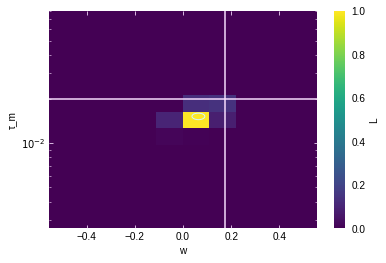

In [10]:
main.plot_likelihood('fsgif_loglikelihood_{}s_sin-input.dat'.format(datalen),
                     ellipse=None,
                     true_params=(true_params.w[0][0],
                                  true_params.τ_m[0]),
                     recalculate=True)

# Model equations

## Spiking model

\begin{gather}
u_{l, i} = \begin{cases}
u_{l-1, i} e^{-Δt/τ_m} + \bigl[u_{rest}^{α(i)} + R I_{ext}^{α(i)}(l) + R I_{syn, i}(l) \bigr]  (1 - e^{-Δt/τ_m}) & \text{if $\hat{t}_i \geq t_{ref}^{α(i)}$} \\
u_{rest}^{α(i)} & \text{otherwise}
\end{cases}
\end{gather}